# OpenSearch Search Test

This notebook tests search functionality after document indexing.

## Environment Setup

In [1]:
import os
from dotenv import load_dotenv

# Load environment variables
load_dotenv('../.env')

os.environ['AWS_DEFAULT_REGION'] = os.getenv('AWS_DEFAULT_REGION', 'us-west-2')
os.environ['AWS_REGION'] = os.getenv('AWS_REGION', 'us-west-2')

print(f"AWS Region: {os.environ['AWS_DEFAULT_REGION']}")

AWS Region: us-west-2


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys

def add_python_path(module_path):
    if os.path.abspath(module_path) not in sys.path:
        sys.path.append(os.path.abspath(module_path))
        print(f"python path: {os.path.abspath(module_path)} is added")
    else:
        print(f"python path: {os.path.abspath(module_path)} already exists")

module_path = ".."
add_python_path(module_path)

python path: /home/ubuntu/projects/aws-ai-ml-workshop-kr/genai/aws-gen-ai-kr/50_tool_repo/rag is added


## 1. Setup Bedrock Client

In [4]:
from pprint import pprint
from termcolor import colored
from src.utils import bedrock
from src.utils.bedrock import bedrock_info

In [5]:
boto3_bedrock = bedrock.get_bedrock_client(
    assumed_role=os.environ.get("BEDROCK_ASSUME_ROLE", None),
    endpoint_url=os.environ.get("BEDROCK_ENDPOINT_URL", None),
    region=os.environ.get("AWS_DEFAULT_REGION", None),
)

print(colored("\n== FM lists ==", "green"))
pprint(bedrock_info.get_list_fm_models(verbose=False))

boto3 Bedrock client successfully created!
bedrock-runtime(https://bedrock-runtime.us-west-2.amazonaws.com)

== FM lists ==
{'Claude-Instant-V1': 'anthropic.claude-instant-v1',
 'Claude-V1': 'anthropic.claude-v1',
 'Claude-V2': 'anthropic.claude-v2',
 'Claude-V2-1': 'anthropic.claude-v2:1',
 'Claude-V3-5-Sonnet': 'anthropic.claude-3-5-sonnet-20240620-v1:0',
 'Claude-V3-5-V-2-Sonnet': 'anthropic.claude-3-5-sonnet-20241022-v2:0',
 'Claude-V3-5-V-2-Sonnet-CRI': 'us.anthropic.claude-3-5-sonnet-20241022-v2:0',
 'Claude-V3-7-Sonnet-CRI': 'us.anthropic.claude-3-7-sonnet-20250219-v1:0',
 'Claude-V3-Haiku': 'anthropic.claude-3-haiku-20240307-v1:0',
 'Claude-V3-Opus': 'anthropic.claude-3-sonnet-20240229-v1:0',
 'Claude-V3-Sonnet': 'anthropic.claude-3-sonnet-20240229-v1:0',
 'Claude-V4-1-Opus-CRI': 'us.anthropic.claude-opus-4-1-20250805-v1:0',
 'Claude-V4-5-Sonnet-CRI': 'global.anthropic.claude-sonnet-4-5-20250929-v1:0',
 'Claude-V4-Opus-CRI': 'us.anthropic.claude-opus-4-20250514-v1:0',
 'Claude-

## 2. Load Models from .env

In [6]:
from langchain_aws import ChatBedrock, BedrockEmbeddings
from langchain_core.callbacks.streaming_stdout import StreamingStdOutCallbackHandler

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [7]:
# Load model configuration from .env
llm_model_name = os.getenv('LLM_MODEL_NAME', 'Claude-V4-5-Sonnet-CRI')
embedding_model_name = os.getenv('EMBEDDING_MODEL_NAME', 'Cohere-Embed-V4-CRI')
embedding_dimension = int(os.getenv('EMBEDDING_DIMENSION', '1024'))

print(colored(f"LLM Model: {llm_model_name}", "cyan"))
print(colored(f"Embedding Model: {embedding_model_name} (dimension={embedding_dimension})", "cyan"))

LLM Model: Claude-V4-5-Sonnet-CRI
Embedding Model: Cohere-Embed-V4-CRI (dimension=1024)


In [8]:
# Initialize LLM
llm_text = ChatBedrock(
    model_id=bedrock_info.get_model_id(model_name=llm_model_name),
    client=boto3_bedrock,
    streaming=True,
    callbacks=[StreamingStdOutCallbackHandler()],
    model_kwargs={
        "max_tokens": 16384,
    }
)

print(colored("LLM loaded successfully", "green"))

LLM loaded successfully


In [9]:
# Initialize Embedding Model
llm_emb = BedrockEmbeddings(
    client=boto3_bedrock,
    model_id=bedrock_info.get_model_id(model_name=embedding_model_name),
    model_kwargs={
        "output_dimension": embedding_dimension,
        "embedding_types": ["float"],
        "input_type": "search_query"  # For search queries
    }
)

print(colored(f"Embedding model loaded: dimension={embedding_dimension}", "green"))

Embedding model loaded: dimension=1024


## 3. Setup OpenSearch Connection

In [10]:
# Load OpenSearch configuration from .env
index_name = os.getenv('INDEX_NAME', 'complex-doc-index')
opensearch_domain_endpoint = os.getenv('OPENSEARCH_DOMAIN_ENDPOINT')
opensearch_user_id = os.getenv('OPENSEARCH_USER_ID')
opensearch_user_password = os.getenv('OPENSEARCH_USER_PASSWORD')

# Validate credentials
if not all([opensearch_domain_endpoint, opensearch_user_id, opensearch_user_password]):
    raise ValueError("OpenSearch credentials not found in .env file")

print(colored(f"Index name: {index_name}", "cyan"))
print(colored(f"OpenSearch endpoint: {opensearch_domain_endpoint}", "cyan"))

Index name: complex-doc-index
OpenSearch endpoint: https://search-dongjin-os-5gpta4ndudcjz354thd4hgokbi.us-west-2.es.amazonaws.com


In [11]:
http_auth = (opensearch_user_id, opensearch_user_password)

In [12]:
from src.utils.opensearch import opensearch_utils

aws_region = os.environ.get("AWS_DEFAULT_REGION", None)

os_client = opensearch_utils.create_aws_opensearch_client(
    aws_region,
    opensearch_domain_endpoint,
    http_auth
)

print(colored("OpenSearch client created", "green"))

OpenSearch client created


## 4. Initialize Hybrid Search Retriever

In [13]:
from src.utils.agentic_rag import rag_chain, OpenSearchHybridSearchRetriever
from src.utils.agentic_rag import show_context_used

In [14]:
opensearch_hybrid_retriever = OpenSearchHybridSearchRetriever(
    os_client=os_client,
    index_name=index_name,
    llm_text=llm_text,
    llm_emb=llm_emb,
    
    # Lexical search options
    minimum_should_match=1,
    filter=[],
    
    # Search fusion options
    fusion_algorithm="RRF",  # Rank fusion algorithm
    ensemble_weights=[.51, .49],  # [semantic, lexical]
    reranker=False,
    parent_document=True,
    
    # Complex document options
    complex_doc=True,
    
    # Async options
    async_mode=True,
    
    # Output options
    k=10,  # Number of documents to return
    verbose=False,
)

print(colored("Hybrid search retriever initialized", "green"))

Hybrid search retriever initialized


## 5. Test Hybrid Search

In [15]:
%%time
query = "만기 상환 수익금 알려줘"
search_hybrid_result, tables, images = opensearch_hybrid_retriever.invoke(query)

CPU times: user 144 ms, sys: 7.62 ms, total: 152 ms
Wall time: 534 ms



-----------------------------------------------
1. Category: Table, Chunk: 365 Characters
-----------------------------------------------


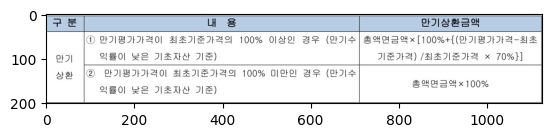

# 만기 상환 조건 요약

이 표는 투자상품의 만기 시 상환 금액 결정 방식을 설명합니다.

**주요 내용:**

1. **만기평가가격이 최초기준가격의 100% 이상인 경우**
   - 수익률이 낮은 기초자산을 기준으로 판단
   - 상환금액 = 총액면금액 × [100% + (수익률 × 70%)]
   - 즉, 원금 + 수익의 70%를 지급

2. **만기평가가격이 최초기준가격의 100% 미만인 경우**
   - 수익률이 낮은 기초자산을 기준으로 판단
   - 상환금액 = 총액면금액 × 100%
   - 원금만 전액 보장

**특징:** 원금보장형 구조로, 손실 발생 시에도 원금은 보호되며, 수익 발생 시 그 70%를 추가로 지급하는 방식입니다.


metadata:
 {'origin_table': '| 구 분 | 내 용 | 만기상환금액 |\n| --- | --- | --- |\n| 만기 상환 | ① 만기평가가격이 최초기준가격의 100% 이상인
경우 (만기수 익률이 낮은 기초자산 기준) | 총액면금액×[100%+{(만기평가가격-최초 기준가격) /최초기준가격 × 70%}] |\n| 만기 상환 | ② 만기평가가격이
최초기준가격의 100% 미만인 경우 (만기수 익률이 낮은 기초자산 기준) | 총액면금액×100% |\n', 'text_as_html': '| 구 분 | 내 용 | 만기상환금액
|\n| --- | --- | --- |\n| 만기 상환 | ① 만기평가가격이 최초기준가격의 100% 이상인 경우 (만기수 익률이 낮은 기초자산 기준) |
총액면금액×[100%+{(만기평가가격-최초 기준가격) /최초기준가격 × 70%}] |\n| 만기 상환 | ② 만기평가가격이 최초기준가격의 100% 미만인 경우 (만기수 익률이 낮은
기초자산 기준) | 총액면금액×100% |\n', 'category': 'Table', 'image_base64': '', 'family_tree': 'parent_table',
'parent_id': 'NA', 'id': 'd9b6b2b8-5d44-4bff-acb0-9ad65ea18aa9', 'origin_image': '',
'orig_elements': ''}

-----------------------------------------------
2. Chunk: 981 Characters
-----------------------------------------------
핵 심 설 명 서

이 설명서는 금융소비자의 권익 보호 및 금융상품에 대한 이해 증진을 위하여
금융상품의 핵심내용을 쉽게 이해하실 수 있도록 작성한 것입니다. 상품내용을
충분히 이해하신 다음에 청약여부를 결정하시기 바랍니다.

# 핵심설명서

# [미래에셋증권 제 253 회 파생결합증권(DLS)(원금보장형)]

# 1



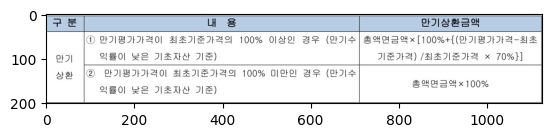

# 문서 분석 결과

## 1. 표 제목
**만기상환금액 계산 구조**

## 2. 요약
이 표는 파생결합증권(DLS)의 만기상환금액 계산 방식을 두 가지 시나리오로 구분하여 제시하고 있습니다. 만기평가가격과 최초기준가격의 관계에 따라 상환금액이 달라지는 구조를
보여줍니다.

## 3. 주요 구성 요소

### 구분 및 조건

**① 만기평가가격이 최초기준가격의 100% 이상인 경우**
- **조건**: 만기수익률이 낮은 기초자산 기준 적용
- **상환금액 계산식**:
  ```
  총액면금액 × [100% + {(만기평가가격 - 최초기준가격) / 최초기준가격 × 70%}]
  ```
- **특징**: 수익 참여율 70% 적용, 두 기초자산 중 수익률이 낮은 것을 기준으로 계산

**② 만기평가가격이 최초기준가격의 100% 미만인 경우**
- **조건**: 만기수익률이 낮은 기초자산 기준 적용
- **상환금액 계산식**:
  ```
  총액면금액 × 100%
  ```
- **특징**: 원금 100% 보장 (원금보장형 상품의 핵심)

### 기초자산 정보
- **KOSPI200 지수**: 블룸버그 티커 KOSPI2 index
- **금가격지수**: 블룸버그 티커 GOLDLNPM index
- **평가 방식**: 두 자산 중 만기수익률이 낮은 자산을 기준으로 계산

### 상품 기본 정보
- **상품명**: 미래에셋증권 제253회 파생결합증권(DLS)(원금보장형)
- **모집가액**: 100억원
- **발행일**: 2011년 07월 08일
- **만기일**: 2012년 07월 09일 (만기 1년)
- **청약단위**: 100만원 이상 100만원 단위

## 4. 가상 질문

**Q1. 두 기초자산의 수익률이 다를 경우 어떻게 계산되나요?**
- A: 만기수익률이 낮은 기초자산을 기준으로 만기상환금액이 계산됩니다. 예를 들어, KOSPI200의 수익률이 높더라도 금가격지수의 수익률이 낮으면 금가격지수를 기준으로
계산합니다.

**Q2. 원금보장은 어떤 경우에 적용

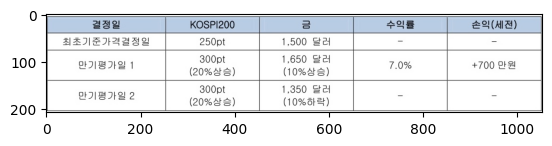

# 표 요약

이 표는 KOSPI200 지수와 금 가격을 기초자산으로 하는 투자상품의 수익 구조를 보여줍니다.

**주요 내용:**

- **기준가격**: KOSPI200 250pt, 금 1,500달러에서 시작
- **만기평가일 1**: 두 자산 모두 상승(KOSPI200 20%↑, 금 10%↑) → 수익률 7.0%, 손익 +700만원 발생
- **만기평가일 2**: KOSPI200은 20% 상승했으나 금이 10% 하락 → 수익 없음

**특징**: 두 기초자산이 모두 상승해야만 수익이 발생하는 구조로, 한 자산이라도 하락하면 수익이 실현되지 않는 조건부 수익 상품입니다.


metadata:
 {'origin_table': '| 결정일 | KOSPI200 | 금 | 수익률 | 손익(세전) |\n| --- | --- | --- | --- | --- |\n|
최초기준가격결정일 | 250pt | 1,500 달러 | - | - |\n| 만기평가일 1 | 300pt (20%상승) | 1,650 달러 (10%상승) | 7.0% | +700
만원 |\n| 만기평가일 2 | 300pt (20%상승) | 1,350 달러 (10%하락) | - | - |\n', 'text_as_html': '| 결정일 | KOSPI200 |
금 | 수익률 | 손익(세전) |\n| --- | --- | --- | --- | --- |\n| 최초기준가격결정일 | 250pt | 1,500 달러 | - | - |\n|
만기평가일 1 | 300pt (20%상승) | 1,650 달러 (10%상승) | 7.0% | +700 만원 |\n| 만기평가일 2 | 300pt (20%상승) | 1,350 달러
(10%하락) | - | - |\n', 'category': 'Table', 'image_base64': '', 'family_tree': 'parent_table',
'parent_id': 'NA', 'id': '2e688e06-58a7-467f-8578-462b2fed3e79', 'origin_image': '',
'orig_elements': ''}

-----------------------------------------------
6. Chunk: 481 Characters
-----------------------------------------------
이 설명서는 금융소비자의 권익 보호 및 금융상품에 대한 이해 증진을 위하여
금융상품의 핵심내용을 쉽게 이해하실 수 있도록 작성한 것입니다. 상품내용을
충분히 이해하신 다음에 청약여부를 결정하시기 바랍니다.

# ※ 손익구조 그래프

![image](/image/placeholder)
수익률 그래프


# ※ 투자손익 

In [16]:
show_context_used(search_hybrid_result)

## 6. Test RAG (Retrieval-Augmented Generation)

In [17]:
from textwrap import dedent

In [18]:
system_prompt = dedent(
    """
    You are a master answer bot designed to answer user's questions.
    I'm going to give you contexts which consist of texts, tables and images.
    Read the contexts carefully, because I'm going to ask you a question about it.
    """
)

human_prompt = dedent(
    """
    Here is the contexts as texts: <contexts>{contexts}</contexts>

    First, find a few paragraphs or sentences from the contexts that are most relevant to answering the question.
    Then, answer the question as much as you can.

    Skip the preamble and go straight into the answer.
    Don't insert any XML tag such as <contexts> and </contexts> when answering.
    Answer in Korean.

    Here is the question: <question>{question}</question>

    If the question cannot be answered by the contexts, say "No relevant contexts".
    """
)

In [19]:
qa = rag_chain(
    llm_text=llm_text,
    retriever=opensearch_hybrid_retriever,
    system_prompt=system_prompt,
    human_prompt=human_prompt,
    return_context=True,
    verbose=False,
)

In [20]:
query = "만기 상환금액에 대해서 알려줘"

response, contexts = qa.invoke(query=query)

verbose False
## 만기 상환금액 안내

이 상품의 만기 상환금액은 만기평가가격과 최초기준가격의 비교에 따라 다음과 같이 결정됩니다:

### ① 만기평가가격이 최초기준가격의 100% 이상인 경우
- **조건**: 만기수익률이 낮은 기초자산을 기준으로 판단
- **상환금액**: 총액면금액 × [100% + {(만기평가가격-최초기준가격) / 최초기준가격 × 70%}]
- **의미**: 원금 + 수익의 70%를 지급받습니다.

**실제 사례**: 1억원 투자 시, 금가격지수가 $1,500에서 $1,650으로 상승한 경우
→ 1억 700만원 지급 (10% 상승 × 70% = 7% 수익)

### ② 만기평가가격이 최초기준가격의 100% 미만인 경우
- **조건**: 만기수익률이 낮은 기초자산을 기준으로 판단
- **상환금액**: 총액면금액 × 100%
- **의미**: 원금 100%를 보장받습니다.

**실제 사례**: 1억원 투자 시, 금가격지수가 $1,500에서 $1,350으로 하락한 경우
→ 1억원 지급 (원금보장)

### 핵심 특징
- **원금보장형 구조**: 기초자산 가격이 하락해도 투자원금은 100% 보장
- **두 기초자산 중 낮은 수익률 기준**: KOSPI200 지수와 금가격지수 중 만기수익률이 낮은 것을 기준으로 계산
- **수익 참여율 70%**: 기초자산 상승 시 상승률의 70%만 투자수익으로 반영

## 7. Custom Query Test

In [21]:
# Test with your own query
custom_query = "원금보장형 상품의 특징은?"

# Use perform_rag_with_agent (async function)
response, contexts = asyncio.run(perform_rag_with_agent(custom_query))

NameError: name 'asyncio' is not defined

In [22]:
# Test with your own query
custom_query = "원금보장형 상품의 특징은?"

response, contexts = qa.invoke(query=custom_query)

verbose False
제공된 문서에서 원금보장형 상품의 특징을 찾을 수 있습니다:

## 원금보장형 상품의 주요 특징

**1. 원금 100% 보장**
만기평가가격이 최초기준가격의 100% 미만인 경우(즉, 기초자산 가격이 하락한 경우)에도 투자원금을 전액 보장받습니다. 상환금액은 "총액면금액×100%"로 계산됩니다.

**2. 제한적 수익 참여**
만기평가가격이 최초기준가격의 100% 이상인 경우, 수익의 70%만 참여합니다. 상환금액은 "총액면금액×[100%+{(만기평가가격-최초기준가격)/최초기준가격 × 70%}]"로 계산됩니다.

**3. 최대 손실 제한**
문서에 명시된 바와 같이 "본 상품은 원금보장형으로 최대 투자손실 발생사례가 존재하지 않습니다."

**4. 중도상환 시 주의사항**
원금보장형이라 하더라도 중도상환 시에는 원금손실이 발생할 수 있습니다. 발행 후 6개월 미만인 경우 공정가액의 90%이상, 6개월 이상인 경우 공정가액의 95%이상을 지급합니다.

**5. 손익구조**
- 하방: 원금 100% 보장으로 손실 위험 최소화
- 상방: 상승분의 70%만 참여하여 수익률 제한적
- 보수적 투자상품: 안정성을 중시하는 투자자에게 적합한 구조